In [1]:
import pandas as pd
import numpy as np
import torch
from torch import optim
from datetime import timedelta
from torch.utils.data import DataLoader,TensorDataset
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
import plotly.express as px
import plotly.graph_objects as go
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from TST import TimeSeriesTransformer
from LSTM import COVID_LSTM
from GRU import COVID_GRU

%matplotlib inline
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 
from Utils import count_parameters, cumulative_to_daily, daily_to_cumulative

# Importing Dataset

In [2]:
state = 'VA'
df = pd.read_csv('us-vaccines.csv').drop(['Code'],1)
vaccines_cumulative = df[df['Entity']=='Virginia']['people_vaccinated'].to_numpy().reshape(-1, 1)

In [3]:
print("Currently Vaccinated Untill today in {} is {}".format(state,vaccines_cumulative[-1]))

Currently Vaccinated Untill today in VA is [4194146]


States to be worked on are:
- California: 39,512,223
- New York: 19,453,561
- Virginia: 8,535,519

# Preprocessing Data

In [4]:
scaler = MinMaxScaler(feature_range=(-1,+1.0))
vaccines_daily = cumulative_to_daily(vaccines_cumulative)
vaccines_daily_normalized = scaler.fit_transform(vaccines_daily.reshape(-1, 1))

In [5]:
def convert_to_slide_window(data,time_steps):
    X, y = [], []
    # Stride = 1
    # The (y) in our case is just the next timestep to compare with it
    for i in range(len(data) - time_steps):
        x = data[i:(i+time_steps)]
        X.append(x)
        y.append(data[i+time_steps])
    return X,y

In [6]:
window_size = 30

X,Y = convert_to_slide_window(vaccines_daily_normalized,window_size)

X_all, y_all = torch.FloatTensor(X).to(device), torch.FloatTensor(Y).to(device) # Full data to be trained on

# Load into DataLoader
all_loader = DataLoader(TensorDataset(X_all, y_all),batch_size=32, shuffle=True)

# y_train_inverse = scaler.inverse_transform(y_train.cpu().detach().numpy())

# TST Model

In [7]:
import gc
gc.collect()

4

In [8]:
TST_model = TimeSeriesTransformer(n_features=1,d_model=128, n_heads=8, n_hidden=128, n_layers=8 ).to(device)
criterion=torch.nn.MSELoss()
# 0.00001 is the best LR for TST
optimizer = optim.Adam(TST_model.parameters(), lr=0.00001)
all_epochs_loss = TST_model.train_model(all_loader,criterion,optimizer,n_epochs = 100 )

Epoch 1 Loss is 0.21522357066472372
Epoch 2 Loss is 0.14166659861803055
Epoch 3 Loss is 0.08808850993712743
Epoch 4 Loss is 0.060264840722084045
Epoch 5 Loss is 0.03818554679552714
Epoch 6 Loss is 0.032217107713222504
Epoch 7 Loss is 0.03183429812391599
Epoch 8 Loss is 0.03516109039386114
Epoch 9 Loss is 0.03931632141272227
Epoch 10 Loss is 0.03638505997757117
Epoch 11 Loss is 0.033511574690540634
Epoch 12 Loss is 0.03394451240698496
Epoch 13 Loss is 0.03633653869231542
Epoch 14 Loss is 0.032992431273063026
Epoch 15 Loss is 0.032638054341077805
Epoch 16 Loss is 0.03344479824105898
Epoch 17 Loss is 0.03148082767923673
Epoch 18 Loss is 0.03310558758676052
Epoch 19 Loss is 0.03261051078637441
Epoch 20 Loss is 0.03554798352221648
Epoch 21 Loss is 0.02996583158771197
Epoch 22 Loss is 0.032933332646886505
Epoch 23 Loss is 0.031848678986231484
Epoch 24 Loss is 0.03368780389428139
Epoch 25 Loss is 0.033077420045932136
Epoch 26 Loss is 0.03330305963754654
Epoch 27 Loss is 0.03378709405660629
Ep

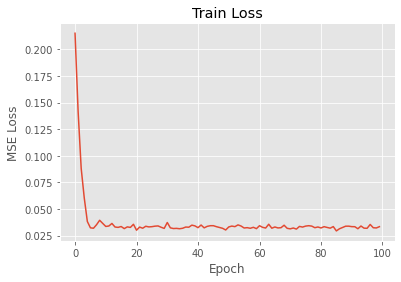

In [9]:
# Epoch 300 Loss is 0.0021550819316568473
fig, ax = plt.subplots()
plt.plot(all_epochs_loss)

ax.set_title('Train Loss')
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE Loss')
plt.show()

In [10]:
torch.FloatTensor(X).to(device).shape

torch.Size([80, 30, 1])

In [11]:
import gc
gc.collect()

0

In [12]:
def forecast_TST(model, X, forecast_len,n_seed):
    model.eval()
    datapoint = X.unsqueeze(1) # [S,B,E]
    torch.cuda.empty_cache()
    for t in range(forecast_len): 
        
        predicted = model(datapoint,None,None).to(device) # [S,B,E] 
        one_new_timestep=predicted[-1,:,:].unsqueeze(0) # [S,B,E]  -> Get the last predicted timestep
        datapoint = torch.cat((datapoint,one_new_timestep),0)  # add the forecasted timestep
    print(datapoint.shape)
    forecasted = datapoint.squeeze()[n_seed:,] # Skip the first (n)seed timesteps cuz are n_seed
    return forecasted

forecasted_days_normalized = forecast_TST(TST_model,X=X_all[-1],forecast_len=115,n_seed = window_size )

torch.Size([145, 1, 1])


In [13]:
forecasted_days_normalized.shape

torch.Size([115])

In [14]:
daily_forecasted__nonNormalized = scaler.inverse_transform(forecasted_days_normalized.cpu().detach().numpy().reshape(-1, 1))
cumulative_forecasted = daily_to_cumulative(daily_forecasted__nonNormalized)

In [15]:
vaccines_cumulative[-1] + cumulative_forecasted[-1]

array([8656773.5])

In [16]:
vaccines_cumulative[-1] 

array([4194146])

In [17]:
cumulative_forecasted[-1]

array([4462627.5], dtype=float32)

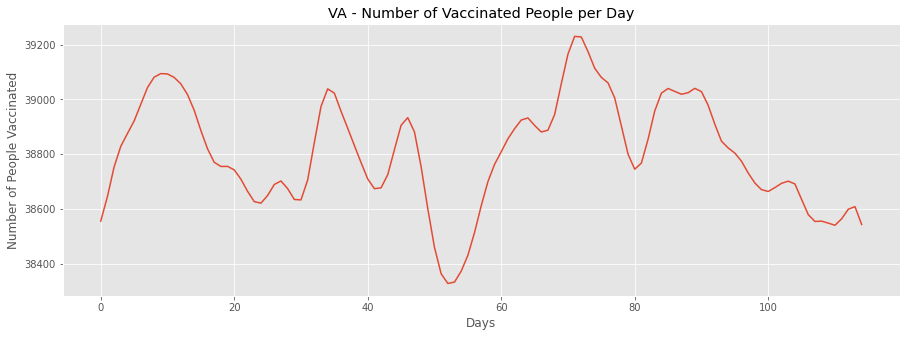

In [19]:
fig, ax = plt.subplots()
# ax.set_ylim([0.0,1.1])

plt.plot(daily_forecasted__nonNormalized)

# plt.plot(forecasted_once_TST[:,0].cpu().detach().numpy(),label='Forecast Function - TST',marker='o')
fig.set_size_inches(15, 5)
ax.set_title('{} - Number of Vaccinated People per Day'.format(state))
ax.set_xlabel('Days')
ax.set_ylabel('Number of People Vaccinated')
# leg = ax.legend(bbox_to_anchor=(1.15, 1.01))
plt.show()